In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import seaborn as sns
%matplotlib inline

In [2]:
#функция для заполнения нулевых значений медианами
#df - название датафрейма, args - название столбцов
#в конце вывожу оставшиеся нулевые значения в столбце, чтобы удостовериться
#в замещении нулей
def full_zeros(df, *args):
    for n in args:
        df.loc[df[n] == 0, n] = df[n].median()
        return df[df[n] == 0 ]

In [3]:
#функция для замены выпадающих маленьких значений на медиану
#df - название датафрейма, column - название столбца, value - какое значение считается выпадающим
def change_to_median_less(df, column, value):
    df.loc[df[column] < value, column] = df[column].median()

In [4]:
#функция для замены выпадающих больших значений на медиану
#df - название датафрейма, column - название столбца, value - какое значение считается выпадающим
def change_to_median_more(df, column, value):
    df.loc[df[column] > value, column] = df[column].median()

In [5]:
#функция для замены выпадающих значений, равных определенному числу, на медиану
#df - название датафрейма, column - название столбца, value - какое значение считается выпадающим
def change_to_median_equal(df, column, value):
    df.loc[df[column] == value, column] = df[column].median()

In [6]:
#функция, чтобы выявлять выпадающие значения
#df - название датафрейма,column_1 - столбец с целевым значение, column_2 - столбец с параметром квартиры
def violin (df, column_1, column_2, plot_name):
    plt.figure(figsize=(25, 8))

    sns.violinplot(df[column_1], df[column_2])

    plt.xlabel(column_1)
    plt.ylabel(column_2)
    plt.title(plot_name)
    plt.show()

### R_baseline = 0.5094293058748917 - значение при использовании модели LinearRegression

# Обработка данных

In [7]:
train_data = r"C:\Users\Nick\Desktop\project_task\train.csv"
test_data = r"C:\Users\Nick\Desktop\project_task\test.csv"

In [8]:
train = pd.read_csv(train_data)
test = pd.read_csv(test_data)

In [9]:
#объединяю тестовые и тренировочные данные
new_data = pd.concat([train, test])
new_data = new_data.reset_index(drop=True)
new_data.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


In [10]:
#превращаю столбец Id в object, чтобы далее его удалить и модель не использовала этот столбец для обучения
new_data.astype({'Id': 'object'}).dtypes

Id                object
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [11]:
#опыт показал, что удаление данных столбцов не приводит к снижения r2. Удаляем столбцы
new_data = new_data.drop(['Id', 'Ecology_2', 'Ecology_3', 'Shops_2'], axis=1)
new_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   DistrictId     15000 non-null  int64  
 1   Rooms          15000 non-null  float64
 2   Square         15000 non-null  float64
 3   LifeSquare     11846 non-null  float64
 4   KitchenSquare  15000 non-null  float64
 5   Floor          15000 non-null  int64  
 6   HouseFloor     15000 non-null  float64
 7   HouseYear      15000 non-null  int64  
 8   Ecology_1      15000 non-null  float64
 9   Social_1       15000 non-null  int64  
 10  Social_2       15000 non-null  int64  
 11  Social_3       15000 non-null  int64  
 12  Healthcare_1   7825 non-null   float64
 13  Helthcare_2    15000 non-null  int64  
 14  Shops_1        15000 non-null  int64  
 15  Price          10000 non-null  float64
dtypes: float64(8), int64(8)
memory usage: 1.8 MB


In [12]:
#заполняем нулевые значения на медиану в столбцах, где не должно быть нуля
#0 в столбце 'Rooms' может означать квартиру-студию, в столбце 'Floor' - цокольный этаж, поэтому не заменяю нули
full_zeros(new_data, 'LifeSquare', 'KitchenSquare', 'HouseFloor')

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price


### Заполняю нулевые значения

In [13]:
new_data.loc[new_data['LifeSquare'].isnull(), 'LifeSquare'] = new_data['LifeSquare'].median()

In [14]:
new_data.loc[new_data['Healthcare_1'].isnull(), 'Healthcare_1'] = new_data['Healthcare_1'].median()

In [15]:
new_data.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,1.500000e+04,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,10000.000000
mean,50.693600,1.897000,56.360350,36.004631,6.174467,8.561800,12.606600,3.321575e+03,0.119196,24.769267,5370.404933,8.113667,1027.371400,1.319467,4.235133,214138.857399
std,43.786257,0.839229,20.423913,63.223093,24.016979,5.323113,6.780165,1.637078e+05,0.119371,17.532278,4013.364403,23.841946,753.341372,1.489012,4.796545,92872.293865
min,0.000000,0.000000,1.136859,0.333490,0.000000,1.000000,0.000000,1.908000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,20.000000,1.000000,41.814371,25.640728,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,830.000000,0.000000,1.000000,153872.633942
50%,37.000000,2.000000,52.645757,32.822810,6.000000,7.000000,12.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,75.000000,2.000000,66.036608,41.522309,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7287.000000,5.000000,990.000000,2.000000,6.000000,249135.462171
max,212.000000,19.000000,641.065193,7480.592129,2014.000000,78.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


### Ищем выпадающие значения в столбцах

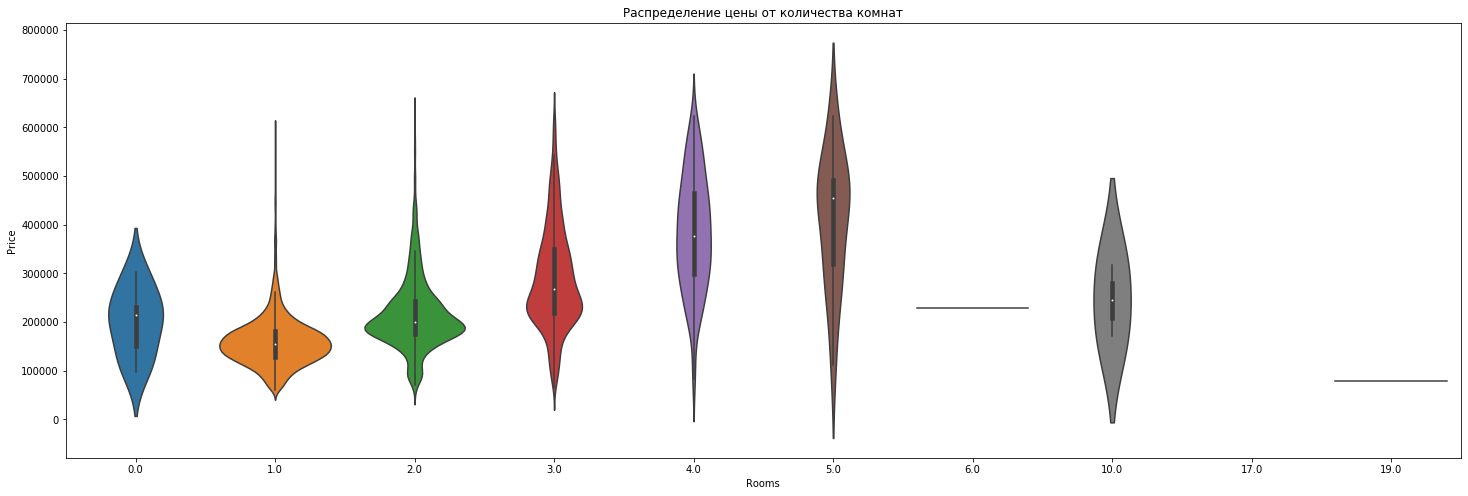

In [16]:
violin(new_data, 'Rooms', 'Price', 'Распределение цены от количества комнат')

Квартиры с 6-ю комнатами и более встречаются крайне редко. Возможно есть смысл удалить такие значения, чтобы модель в дальнейшем не путалась. Необходимо понять какую долю от общей выборки занимают жти выбросы. Если это доля большая удалять нельзя

In [17]:
#Выпадающих значений всего 6. Меняю их на медиану
new_data['Rooms'].value_counts()

2.0     5910
1.0     5474
3.0     3334
4.0      240
5.0       25
0.0       10
6.0        3
10.0       2
19.0       1
17.0       1
Name: Rooms, dtype: int64

In [18]:
change_to_median_more(new_data, 'Rooms', 5)
new_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   DistrictId     15000 non-null  int64  
 1   Rooms          15000 non-null  float64
 2   Square         15000 non-null  float64
 3   LifeSquare     15000 non-null  float64
 4   KitchenSquare  15000 non-null  float64
 5   Floor          15000 non-null  int64  
 6   HouseFloor     15000 non-null  float64
 7   HouseYear      15000 non-null  int64  
 8   Ecology_1      15000 non-null  float64
 9   Social_1       15000 non-null  int64  
 10  Social_2       15000 non-null  int64  
 11  Social_3       15000 non-null  int64  
 12  Healthcare_1   15000 non-null  float64
 13  Helthcare_2    15000 non-null  int64  
 14  Shops_1        15000 non-null  int64  
 15  Price          10000 non-null  float64
dtypes: float64(8), int64(8)
memory usage: 1.8 MB


In [19]:
#Выдвигаю гипотезу о том, что квартир с площадью меньше 15 кв.м. нет. Проверяю количество таких квартир
new_data[new_data['Square'] < 15]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
212,88,2.0,5.497061,67.628717,1.0,24,22.0,1977,0.127376,43,8429,3,900.0,3,9,412511.088764
1316,27,1.0,4.633498,1.969969,1.0,18,1.0,1977,0.011654,4,915,0,900.0,0,0,107604.269441
1608,6,1.0,2.596351,4.604943,1.0,3,25.0,2014,0.243205,5,1564,0,540.0,0,0,137597.601458
3280,27,1.0,4.380726,40.805837,1.0,10,17.0,2013,0.211401,9,1892,0,900.0,0,1,97560.720383
3413,5,1.0,5.129222,5.549458,1.0,1,1.0,1977,0.150818,16,3433,4,2643.0,4,5,369472.403061
4739,81,3.0,13.784865,15.988889,7.0,4,5.0,1960,0.319809,25,4756,16,2857.0,5,8,78388.806186
4853,27,0.0,2.377248,0.873147,0.0,1,0.0,1977,0.017647,2,469,0,900.0,0,0,126596.941798
4900,27,3.0,4.390331,5.610772,1.0,8,19.0,2016,0.211401,9,1892,0,900.0,0,1,161379.067034
6392,1,1.0,1.136859,4.525736,1.0,3,1.0,1977,0.007122,1,264,0,900.0,0,1,181434.825589
8030,1,3.0,4.823679,79.767964,0.0,6,17.0,1977,0.007122,1,264,0,900.0,0,1,237716.681261


In [20]:
change_to_median_less(new_data, 'Square', 15)

In [21]:
#Проверяю, все ли поменялось
unique_square = new_data.Square.sort_values().unique()
unique_square[:10]

array([16.11715428, 16.3190148 , 16.54724199, 17.04618752, 17.27369918,
       17.41418113, 17.49854229, 18.14926697, 18.50917707, 18.98396246])

In [22]:
#вычисляю коэффициент, который показывает чему будет равен 'LifeSquare' в зависимости от 'Square'
square_lifesquare_coef = (new_data['Square'] / new_data['LifeSquare']).median()
square_lifesquare_coef

1.6313594972167809

In [23]:
#Так же как и с 'Square' выдвигаю гипотезу, что меньше 10 кв.м. жилой площади нет
new_data.loc[new_data['LifeSquare'] < 10, 'LifeSquare'] = new_data['Square'] * square_lifesquare_coef

In [24]:
#Хочу посмотреть распределение 'LifeSquare'  и выявить выпадающие значения
unique_lifesquare = new_data.LifeSquare.sort_values().unique()
unique_lifesquare[-10:]

array([ 208.24505825,  211.23112527,  227.9152869 ,  233.94930927,
        263.54202007,  303.07109439,  410.63974936,  461.46361442,
        638.16319344, 7480.59212893])

In [25]:
new_data.loc[new_data['LifeSquare'] > 1000, 'LifeSquare'] = new_data['Square'] * square_lifesquare_coef

In [26]:
# Встречаются значения 'LifeSquare' > 'Square'. Такого быть не может. Гипотеза о том, что эти значения перепутали местами
mask_square = new_data['Square'] < new_data['LifeSquare']

In [27]:
# Меняю местами 'LifeSquare' и 'Square' в тех случаях, когда 'LifeSquare' > 'Square'
new_data.loc[new_data.loc[mask_square].index, 'Square'], new_data.loc[new_data.loc[mask_square].index, 'LifeSquare'] = new_data.loc[new_data.loc[mask_square].index, 'LifeSquare'], new_data.loc[new_data.loc[mask_square].index, 'Square']

In [28]:
# Гипотеза, что кухни меньше 3 кв.м. нет
new_data[new_data['KitchenSquare'] < 3]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
2,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,34,7759,0,229.0,1,3,220925.908524
7,74,2.0,80.312926,32.822810,0.0,14,0.0,1977,0.075779,6,1437,3,900.0,0,2,221244.156664
8,1,2.0,64.511437,32.822810,1.0,9,17.0,1977,0.007122,1,264,0,900.0,0,1,229102.795999
12,13,2.0,54.522805,31.759753,1.0,8,12.0,1999,0.090799,74,19083,2,900.0,5,15,229220.372609
14,27,1.0,53.769097,52.408027,1.0,5,4.0,1977,0.072158,2,629,1,900.0,0,0,140647.565937
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14982,23,1.0,39.610426,38.187571,1.0,6,18.0,2013,0.034656,0,168,0,900.0,0,0,NaN
14985,1,1.0,46.597283,32.822810,1.0,17,24.0,1977,0.007122,1,264,0,900.0,0,1,NaN
14987,53,3.0,80.102103,32.822810,1.0,13,22.0,1977,0.049637,34,7759,0,229.0,1,3,NaN
14998,62,2.0,81.305222,32.822810,0.0,4,0.0,1977,0.072158,2,629,1,900.0,0,0,NaN


In [29]:
# Ищу минимальные и максимальные значения в 'KitchenSquare'. 
# Заменяю их исходя из уравнения 'KitchenSquare' = 'Square' - 'LifeSquare'
unique_kitchensquare = new_data.KitchenSquare.sort_values().unique()
kitchensquare_min = unique_kitchensquare[:10]
kitchensquare_max = unique_kitchensquare[-10:]
print('Минимальные площади кухни: {}' '\n' 'Максимальные площади кухни: {}'.format(kitchensquare_min, kitchensquare_max))

Минимальные площади кухни: [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
Максимальные площади кухни: [  75.   78.   84.   96.   97.  112.  123.  620. 1970. 2014.]


In [30]:
new_data.loc[new_data['KitchenSquare'] > 100, 'KitchenSquare'] = new_data['Square'] - new_data['LifeSquare']

In [31]:
new_data.loc[new_data['KitchenSquare'] < 3, 'KitchenSquare'] = new_data['Square'] - new_data['LifeSquare']

In [32]:
new_data.loc[new_data['KitchenSquare'] < 2, 'KitchenSquare'] = 2

In [33]:
new_data[new_data['KitchenSquare'] < 2]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price


In [34]:
# Ищу минимальные и максимальные значения в 'Floor'. 
# Заменяю их на медиану
unique_floor = new_data.Floor.sort_values().unique()
floor_min = unique_floor[:10]
floor_max = unique_floor[-10:]
print('Минимальные этажи: {}' '\n' 'Максимальные этажи: {}'.format(floor_min, floor_max))

Минимальные этажи: [ 1  2  3  4  5  6  7  8  9 10]
Максимальные этажи: [28 31 32 33 34 37 38 42 46 78]


In [35]:
change_to_median_equal(new_data, 'Floor', 78)

In [36]:
# Проверяю, отсались ли такие значения
new_data[new_data['Floor'] == 78]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price


In [37]:
# Ищу минимальные и максимальные значения в 'HouseFloor'. 
# Заменяю их на медиану
unique_house_floor = new_data.HouseFloor.sort_values().unique()
house_floor_min = unique_house_floor[:10]
house_floor_max = unique_house_floor[-10:]
print('Минимальные этажи в доме: {}' '\n' 'Максимальные этажи в доме: {}'.format(house_floor_min, house_floor_max))

Минимальные этажи в доме: [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
Максимальные этажи в доме: [ 37.  38.  39.  40.  44.  45.  47.  48.  99. 117.]


In [38]:
change_to_median_equal(new_data, 'HouseFloor', 0)

In [39]:
new_data.loc[new_data['HouseFloor'].isin([99, 117]), 'HouseFloor'] = new_data['HouseFloor'].median()

In [40]:
# Ищу минимальные и максимальные значения в 'HouseFloor'. 
# Заменяю их на медиану
unique_house_year = new_data.HouseYear.sort_values().unique()
house_year_min = unique_house_year[:10]
house_year_max = unique_house_year[-10:]
print('Самые поздние годы: {}' '\n' 'Самые ранние годы: {}'.format(house_year_min, house_year_max))

Самые поздние годы: [1908 1909 1910 1911 1912 1914 1916 1917 1918 1919]
Самые ранние годы: [    2013     2014     2015     2016     2017     2018     2019     2020
     4968 20052011]


In [41]:
change_to_median_more(new_data, 'HouseYear', 2020)

In [42]:
# Пытаюсь не допустить проблему коллинеарности
features = new_data.select_dtypes(include=['float64', 'int64'])

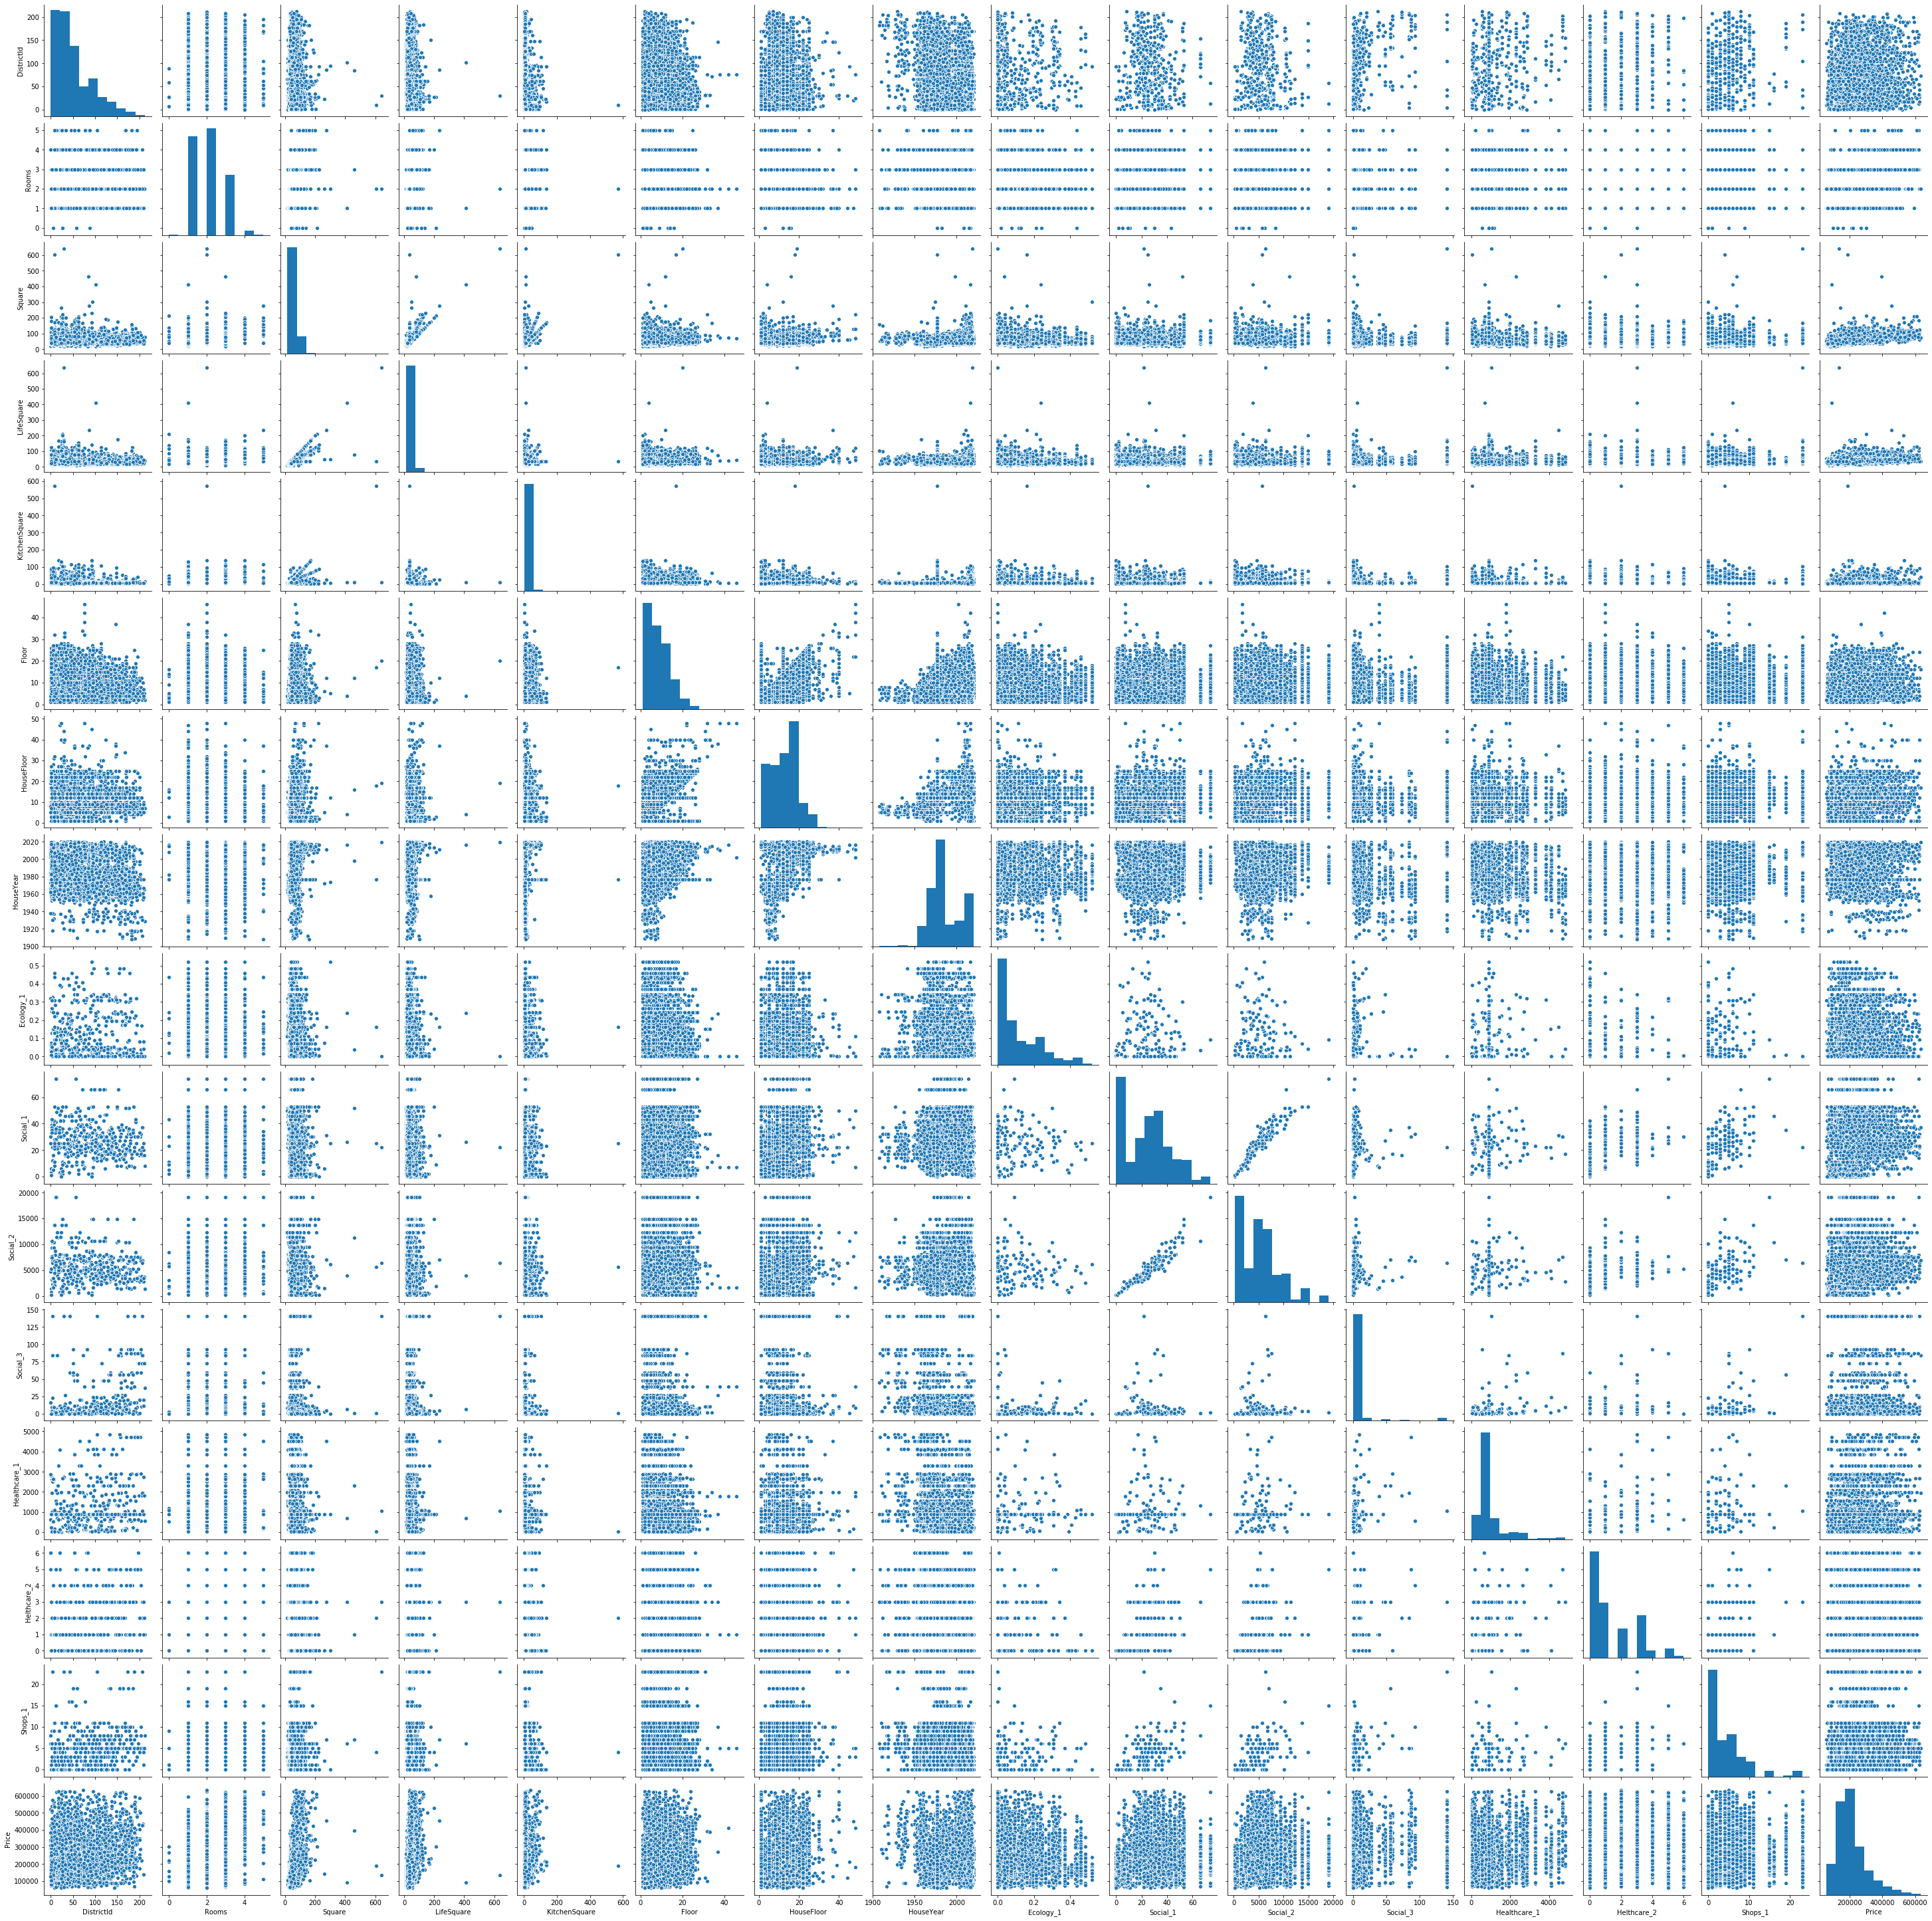

In [43]:
# Ищу параметры, которые коррелируют друг с другом
sns.pairplot(features);

In [44]:
# Такими параметрами стали 'Square' & 'LifeSquare', 'Social_1' & 'Social_2'. Удаляю данные столбцы
new_data = new_data.drop(['LifeSquare', 'Social_2'], axis=1)
new_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   DistrictId     15000 non-null  int64  
 1   Rooms          15000 non-null  float64
 2   Square         15000 non-null  float64
 3   KitchenSquare  15000 non-null  float64
 4   Floor          15000 non-null  float64
 5   HouseFloor     15000 non-null  float64
 6   HouseYear      15000 non-null  float64
 7   Ecology_1      15000 non-null  float64
 8   Social_1       15000 non-null  int64  
 9   Social_3       15000 non-null  int64  
 10  Healthcare_1   15000 non-null  float64
 11  Helthcare_2    15000 non-null  int64  
 12  Shops_1        15000 non-null  int64  
 13  Price          10000 non-null  float64
dtypes: float64(9), int64(5)
memory usage: 1.6 MB


In [45]:
# Также из графика видно, что в 'Square' имеются выбивающиеся значения (> 350). Их не много, поэтому удаляю
new_data.drop(new_data[new_data['Square'] > 350].index, inplace=True)
new_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14996 entries, 0 to 14999
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   DistrictId     14996 non-null  int64  
 1   Rooms          14996 non-null  float64
 2   Square         14996 non-null  float64
 3   KitchenSquare  14996 non-null  float64
 4   Floor          14996 non-null  float64
 5   HouseFloor     14996 non-null  float64
 6   HouseYear      14996 non-null  float64
 7   Ecology_1      14996 non-null  float64
 8   Social_1       14996 non-null  int64  
 9   Social_3       14996 non-null  int64  
 10  Healthcare_1   14996 non-null  float64
 11  Helthcare_2    14996 non-null  int64  
 12  Shops_1        14996 non-null  int64  
 13  Price          9996 non-null   float64
dtypes: float64(9), int64(5)
memory usage: 1.7 MB


# Закончили обработку данных. Выделяем train и test

In [46]:
# Создаю новый параметр, который понадобится для еще одного параметра - Средней цены за кв.м. в каждом районе
new_data['Price_per_square'] = new_data['Price'] / new_data['Square']

In [47]:
# Убеждаюсь, что столбец добавился
new_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14996 entries, 0 to 14999
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   DistrictId        14996 non-null  int64  
 1   Rooms             14996 non-null  float64
 2   Square            14996 non-null  float64
 3   KitchenSquare     14996 non-null  float64
 4   Floor             14996 non-null  float64
 5   HouseFloor        14996 non-null  float64
 6   HouseYear         14996 non-null  float64
 7   Ecology_1         14996 non-null  float64
 8   Social_1          14996 non-null  int64  
 9   Social_3          14996 non-null  int64  
 10  Healthcare_1      14996 non-null  float64
 11  Helthcare_2       14996 non-null  int64  
 12  Shops_1           14996 non-null  int64  
 13  Price             9996 non-null   float64
 14  Price_per_square  9996 non-null   float64
dtypes: float64(10), int64(5)
memory usage: 1.8 MB


In [48]:
# Рассчитываю среднюю цену за кв.м. в каждом районе. Но этот параметр нельзя вставить как столбец в датафрейм.
# Поэтому делаю следующие превращения
DistrictValue_per_square = new_data.groupby(['DistrictId'])['Price_per_square'].median()
DistrictValue_per_square

DistrictId
0      3935.906409
1      3225.378611
2      4550.709250
3      3892.203737
4      5716.888354
          ...     
208    8005.605047
209    4176.437542
210            NaN
211            NaN
212            NaN
Name: Price_per_square, Length: 212, dtype: float64

In [49]:
# Превращаю столбец в np.array и далее в словарь так как не знаю как сделать так, чтобы напротив определенного района
# стояла средняя цена за кв.м.  
DistrictValue_per_square = np.array(DistrictValue_per_square)

In [50]:
d = dict(enumerate(DistrictValue_per_square.flatten(), 1))
d

{1: 3935.906409115417,
 2: 3225.378611195424,
 3: 4550.709249535287,
 4: 3892.2037374001297,
 5: 5716.888354234639,
 6: 4556.996563805134,
 7: 2824.839298568043,
 8: 4562.0267772945335,
 9: 4122.351783292255,
 10: 3205.7570219046925,
 11: 4458.893221811486,
 12: 4134.353749474017,
 13: 4133.475318032655,
 14: 4273.749206965422,
 15: 5014.656719405392,
 16: 3911.3775296942986,
 17: 4377.906782463491,
 18: 5029.78368192822,
 19: 4120.025201223722,
 20: 4296.248343930521,
 21: 5544.800299680768,
 22: 3985.927885989802,
 23: 3517.139428722253,
 24: 2240.4427725217947,
 25: 5008.479259603621,
 26: 4141.272817472811,
 27: 4745.150770301531,
 28: 2719.791324100303,
 29: 4385.488771398001,
 30: 4186.662748188238,
 31: 2787.516398534025,
 32: 5480.216930281392,
 33: 5067.192462664534,
 34: 4748.668640346779,
 35: 4216.621540485727,
 36: 4358.274853343686,
 37: 4664.977121869393,
 38: 4430.244621714515,
 39: 4630.854637207407,
 40: 4249.133232229784,
 41: 4863.1751849124175,
 42: 4437.3040724963

In [51]:
# Вставляю новый столбец
for n in new_data['DistrictId']:
    new_data['DistrictValue_per_square'] = d.get(n)

In [52]:
new_data.astype({'DistrictId': 'object'}).dtypes

DistrictId                   object
Rooms                       float64
Square                      float64
KitchenSquare               float64
Floor                       float64
HouseFloor                  float64
HouseYear                   float64
Ecology_1                   float64
Social_1                      int64
Social_3                      int64
Healthcare_1                float64
Helthcare_2                   int64
Shops_1                       int64
Price                       float64
Price_per_square            float64
DistrictValue_per_square    float64
dtype: object

In [53]:
# Делю данные на исходные тестовые и тренировочные. Но! Так как тренировочные далее будут разбиваться на тестовые
# и тренировочные, выделяю изначально тестовые данные в датафрейм x_homework и y_homework

x = new_data[new_data['Price'].notnull()]
x_homework = new_data[new_data['Price'].isnull()]

y = pd.DataFrame(new_data[new_data['Price'].notnull()], columns=['Price'])
y_homework = pd.DataFrame(new_data[new_data['Price'].isnull()], columns=['Price'])

In [54]:
x = x.drop(['Price', 'Price_per_square'], axis=1)
x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9996 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   DistrictId                9996 non-null   int64  
 1   Rooms                     9996 non-null   float64
 2   Square                    9996 non-null   float64
 3   KitchenSquare             9996 non-null   float64
 4   Floor                     9996 non-null   float64
 5   HouseFloor                9996 non-null   float64
 6   HouseYear                 9996 non-null   float64
 7   Ecology_1                 9996 non-null   float64
 8   Social_1                  9996 non-null   int64  
 9   Social_3                  9996 non-null   int64  
 10  Healthcare_1              9996 non-null   float64
 11  Helthcare_2               9996 non-null   int64  
 12  Shops_1                   9996 non-null   int64  
 13  DistrictValue_per_square  9996 non-null   float64
dtypes: float

In [55]:
y.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9996 entries, 0 to 9999
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Price   9996 non-null   float64
dtypes: float64(1)
memory usage: 156.2 KB


In [56]:
x_homework = x_homework.drop(['Price', 'Price_per_square'], axis=1)
x_homework.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 10000 to 14999
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   DistrictId                5000 non-null   int64  
 1   Rooms                     5000 non-null   float64
 2   Square                    5000 non-null   float64
 3   KitchenSquare             5000 non-null   float64
 4   Floor                     5000 non-null   float64
 5   HouseFloor                5000 non-null   float64
 6   HouseYear                 5000 non-null   float64
 7   Ecology_1                 5000 non-null   float64
 8   Social_1                  5000 non-null   int64  
 9   Social_3                  5000 non-null   int64  
 10  Healthcare_1              5000 non-null   float64
 11  Helthcare_2               5000 non-null   int64  
 12  Shops_1                   5000 non-null   int64  
 13  DistrictValue_per_square  5000 non-null   float64
dtypes: 

In [57]:
from sklearn.ensemble import RandomForestRegressor

In [58]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, shuffle=True, random_state=21)

In [66]:
rf_model = RandomForestRegressor(max_depth=8, n_estimators=100, random_state=21)

In [67]:
rf_model.fit(x_train, y_train)

C:\Users\Nick\anaconda3\lib\site-packages\ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=8, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=21, verbose=0, warm_start=False)

In [68]:
y_pred_train = rf_model.predict(x_train)
r2_new_train = r2_score(y_train, y_pred_train)
r2_new_train

0.7804790891764342

In [69]:
y_pred_test = rf_model.predict(x_test)
r2_new_test = r2_score(y_test, y_pred_test)
r2_new_test

0.7064405396798938

In [71]:
x.to_pickle(r"C:\Users\Nick\Desktop\project_task\x_final_solve.pkl")
y.to_pickle(r"C:\Users\Nick\Desktop\project_task\y_final_solve.pkl")

x_homework.to_pickle(r"C:\Users\Nick\Desktop\project_task\x_final_test_solve.pkl")
y_homework.to_pickle(r"C:\Users\Nick\Desktop\project_task\y_final_test_solve.pkl")

In [73]:
y_test_homework_pred = rf_model.predict(x_homework)

In [77]:
dzhalagoniya_predictions = pd.DataFrame(y_test_homework_pred, columns=['price'])

In [81]:
dzhalagoniya_predictions['id'] = dzhalagoniya_predictions['price'].index

,price,id
0,156691.250619,0
1,194443.241881,1
2,305283.935101,2
3,325876.163085,3
4,132056.140611,4


In [84]:
dzhalagoniya_predictions = dzhalagoniya_predictions[['id', 'price']]

,id,price
0,0,156691.250619
1,1,194443.241881
2,2,305283.935101
3,3,325876.163085
4,4,132056.140611


In [86]:
dzhalagoniya_predictions.to_csv(r"C:\Users\Nick\Desktop\project_task\Dzhalagoniya_predictions.csv", index=False)